# 01 – Planeamento e Recomendação de Castas

Este notebook tem como objetivo desenvolver um modelo de IA para recomendar castas de videira com base nas características de cada talhão (solo, clima, exposição, etc.). O modelo será treinado com dados sintéticos gerados anteriormente.

**Etapas:**
1. Carregar e explorar os dados
2. Preparar as features e o target (corrigido data leakage)
3. Treinar modelos (Random Forest, XGBoost)
4. Avaliar o desempenho
5. Interpretar o modelo com SHAP
6. Conclusões e próximos passos

In [12]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import shap

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [13]:
# 2. Carregar dados
talhoes = pd.read_csv('../data/synthetic/talhoes_com_solo.csv')
clima = pd.read_csv('../data/synthetic/clima_diario_2019_2024.csv', parse_dates=['data'])
prod = pd.read_csv('../data/synthetic/produtividade_anual.csv')

print('Talhões:')
display(talhoes.head())
print('\nClima (amostra):')
display(clima.head())
print('\nProdutividade anual:')
display(prod.head())

Talhões:


,id,area_ha,exposicao,declive_perc,altitude_m,solo,casta,talhao_id,ph,mo_perc,argila_perc,limo_perc,areia_perc,capacidade_agua_mm
0,1,1.2,Sul,15,250,xisto,Touriga Nacional,1,6.196469,1.929209,17.268515,25.513148,59.389379,121.155323
1,2,0.8,Sudoeste,20,300,xisto,Tinta Roriz,2,6.480764,2.527245,19.809319,23.921175,51.863560,136.452485
2,3,1.5,Norte,10,200,xisto_argila,Touriga Franca,3,6.238572,2.089517,28.980443,32.379954,33.649835,138.772588
3,4,1.0,Este,5,180,xisto,Viosinho,4,6.031551,2.297741,21.344010,28.494318,59.489106,130.551176
4,5,0.7,Oeste,25,320,xisto,Tinto C�o,5,6.222443,1.984438,18.617887,22.282632,50.874281,131.548806



Clima (amostra):


,data,t_max,t_min,t_mean,precip_mm,humidade_perc,radiacao_w_m2
0,2019-01-01,11.0,4.1,7.6,0.5,89.6,50.7
1,2019-01-02,9.8,-2.7,3.6,0.0,58.9,68.4
2,2019-01-03,11.4,0.5,5.9,3.0,92.3,58.3
3,2019-01-04,13.1,-1.2,6.0,0.0,59.9,65.8
4,2019-01-05,9.7,1.0,5.3,0.0,56.1,50.0



Produtividade anual:


,ano,talhao_id,casta,produtividade_ton_ha,graus_dia_ciclo,precip_ciclo_mm
0,2019,1,Touriga Nacional,9.52,2087,57.3
1,2019,2,Tinta Roriz,10.07,2087,57.3
2,2019,3,Touriga Franca,10.34,2087,57.3
3,2019,4,Viosinho,5.33,2087,57.3
4,2019,5,Tinto C�o,7.34,2087,57.3


## 3. Engenharia de features (corrigida – sem data leakage)

Para evitar que o modelo use informação do futuro, as features climáticas devem ser **médias históricas do período completo** (2019-2024) em vez de variarem por ano. Assim, cada talhão terá um perfil climático fixo, representativo da região, e a decisão de recomendação pode ser tomada antes da safra.

Vamos também limpar os nomes das colunas resultantes dos merges.

In [14]:
# 3.1 Calcular médias climáticas do período completo (2019-2024)
clima_medio = {
    'temp_media_hist': clima['t_mean'].mean(),
    'temp_max_media_hist': clima['t_max'].mean(),
    'temp_min_media_hist': clima['t_min'].mean(),
    'precip_total_media_hist': clima['precip_mm'].mean() * 365,  # média anual
    'humidade_media_hist': clima['humidade_perc'].mean(),
    'radiacao_media_hist': clima['radiacao_w_m2'].mean()
}

# Converter para DataFrame com uma linha
clima_medio_df = pd.DataFrame([clima_medio])
clima_medio_df

,temp_media_hist,temp_max_media_hist,temp_min_media_hist,precip_total_media_hist,humidade_media_hist,radiacao_media_hist
0,15.00885,20.060219,9.955794,490.368841,62.471168,201.751277


In [15]:
# 3.2 Juntar produtividade com talhões e adicionar clima médio (constante)
# Primeiro merge: prod com talhoes
df = prod.merge(talhoes, left_on='talhao_id', right_on='id', how='left')

# Renomear colunas duplicadas de forma clara
# 'casta' existe em ambos: em prod (casta) e em talhoes (casta). Vamos manter a de talhoes (casta plantada) e descartar a outra.
if 'casta_x' in df.columns and 'casta_y' in df.columns:
    df.rename(columns={'casta_y': 'casta'}, inplace=True)
    df.drop(columns=['casta_x'], inplace=True)

if 'talhao_id_x' in df.columns and 'talhao_id_y' in df.columns:
    df.rename(columns={'talhao_id_x': 'talhao_id'}, inplace=True)
    df.drop(columns=['talhao_id_y'], inplace=True)

# Adicionar as features climáticas constantes (cruzado com todas as linhas)
df = df.assign(**clima_medio)

# Remover colunas que não serão usadas como features
df.drop(columns=['id', 'solo', 'graus_dia_ciclo', 'precip_ciclo_mm'], inplace=True, errors='ignore')

print('Dataset após engenharia:')
display(df.head())
print(df.shape)

Dataset após engenharia:


,ano,talhao_id,produtividade_ton_ha,area_ha,exposicao,declive_perc,altitude_m,casta,ph,mo_perc,argila_perc,limo_perc,areia_perc,capacidade_agua_mm,temp_media_hist,temp_max_media_hist,temp_min_media_hist,precip_total_media_hist,humidade_media_hist,radiacao_media_hist
0,2019,1,9.52,1.2,Sul,15,250,Touriga Nacional,6.196469,1.929209,17.268515,25.513148,59.389379,121.155323,15.00885,20.060219,9.955794,490.368841,62.471168,201.751277
1,2019,2,10.07,0.8,Sudoeste,20,300,Tinta Roriz,6.480764,2.527245,19.809319,23.921175,51.863560,136.452485,15.00885,20.060219,9.955794,490.368841,62.471168,201.751277
2,2019,3,10.34,1.5,Norte,10,200,Touriga Franca,6.238572,2.089517,28.980443,32.379954,33.649835,138.772588,15.00885,20.060219,9.955794,490.368841,62.471168,201.751277
3,2019,4,5.33,1.0,Este,5,180,Viosinho,6.031551,2.297741,21.344010,28.494318,59.489106,130.551176,15.00885,20.060219,9.955794,490.368841,62.471168,201.751277
4,2019,5,7.34,0.7,Oeste,25,320,Tinto C�o,6.222443,1.984438,18.617887,22.282632,50.874281,131.548806,15.00885,20.060219,9.955794,490.368841,62.471168,201.751277


(30, 20)


In [16]:
# 3.3 Codificar variáveis categóricas
# 'exposicao' e 'casta' são categóricas
df = pd.get_dummies(df, columns=['exposicao', 'casta'], prefix=['exp', 'casta'])

# Verificar valores nulos
print('Valores nulos por coluna:')
print(df.isnull().sum())

Valores nulos por coluna:
ano                        0
talhao_id                  0
produtividade_ton_ha       0
area_ha                    0
declive_perc               0
altitude_m                 0
ph                         0
mo_perc                    0
argila_perc                0
limo_perc                  0
areia_perc                 0
capacidade_agua_mm         0
temp_media_hist            0
temp_max_media_hist        0
temp_min_media_hist        0
precip_total_media_hist    0
humidade_media_hist        0
radiacao_media_hist        0
exp_Este                   0
exp_Norte                  0
exp_Oeste                  0
exp_Sudoeste               0
exp_Sul                    0
casta_Tinta Roriz          0
casta_Tinto C�o            0
casta_Touriga Franca       0
casta_Touriga Nacional     0
casta_Viosinho             0
dtype: int64


## 4. Preparação para modelação

O target é a casta plantada em cada linha (já codificada nas colunas `casta_*`). As features incluem:
- Características do talhão (`area_ha`, `declive_perc`, `altitude_m`, `ph`, `mo_perc`, `argila_perc`, `limo_perc`, `areia_perc`, `capacidade_agua_mm`)
- Exposição (codificada em `exp_*`)
- Variáveis climáticas históricas (`temp_media_hist`, `precip_total_media_hist`, etc.)

Nota: excluímos `ano`, `talhao_id`, `produtividade_ton_ha` porque não devem ser usadas para recomendar a casta (ou são identificadores ou só conhecidas após a colheita).

In [17]:
# Selecionar colunas que são features (tudo exceto target e colunas não permitidas)
feature_cols = [col for col in df.columns if not col.startswith('casta_') 
                and col not in ['ano', 'talhao_id', 'produtividade_ton_ha']]
X = df[feature_cols]

# Target: a casta verdadeira (colunas dummy)
casta_cols = [col for col in df.columns if col.startswith('casta_')]
y = df[casta_cols].idxmax(axis=1)  # retorna o nome da coluna com 1

print('Features (primeiras 5 linhas):')
display(X.head())
print('\nTarget (primeiros 5):')
print(y.head())

Features (primeiras 5 linhas):


,area_ha,declive_perc,altitude_m,ph,mo_perc,argila_perc,limo_perc,areia_perc,capacidade_agua_mm,temp_media_hist,temp_max_media_hist,temp_min_media_hist,precip_total_media_hist,humidade_media_hist,radiacao_media_hist,exp_Este,exp_Norte,exp_Oeste,exp_Sudoeste,exp_Sul
0,1.2,15,250,6.196469,1.929209,17.268515,25.513148,59.389379,121.155323,15.00885,20.060219,9.955794,490.368841,62.471168,201.751277,False,False,False,False,True
1,0.8,20,300,6.480764,2.527245,19.809319,23.921175,51.863560,136.452485,15.00885,20.060219,9.955794,490.368841,62.471168,201.751277,False,False,False,True,False
2,1.5,10,200,6.238572,2.089517,28.980443,32.379954,33.649835,138.772588,15.00885,20.060219,9.955794,490.368841,62.471168,201.751277,False,True,False,False,False
3,1.0,5,180,6.031551,2.297741,21.344010,28.494318,59.489106,130.551176,15.00885,20.060219,9.955794,490.368841,62.471168,201.751277,True,False,False,False,False
4,0.7,25,320,6.222443,1.984438,18.617887,22.282632,50.874281,131.548806,15.00885,20.060219,9.955794,490.368841,62.471168,201.751277,False,False,True,False,False



Target (primeiros 5):
0    casta_Touriga Nacional
1         casta_Tinta Roriz
2      casta_Touriga Franca
3            casta_Viosinho
4           casta_Tinto C�o
dtype: object


In [18]:
# Dividir em treino e teste (estratificado para manter proporção das castas)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f'Treino: {X_train.shape}, Teste: {X_test.shape}')

Treino: (24, 20), Teste: (6, 20)


## 5. Treinar modelos

In [19]:
# 5.1 Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print('Random Forest - Acurácia:', accuracy_score(y_test, y_pred_rf))
print('\nRelatório de Classificação:')
print(classification_report(y_test, y_pred_rf))

Random Forest - Acurácia: 1.0

Relatório de Classificação:
                        precision    recall  f1-score   support

     casta_Tinta Roriz       1.00      1.00      1.00         1
       casta_Tinto C�o       1.00      1.00      1.00         1
  casta_Touriga Franca       1.00      1.00      1.00         1
casta_Touriga Nacional       1.00      1.00      1.00         2
        casta_Viosinho       1.00      1.00      1.00         1

              accuracy                           1.00         6
             macro avg       1.00      1.00      1.00         6
          weighted avg       1.00      1.00      1.00         6



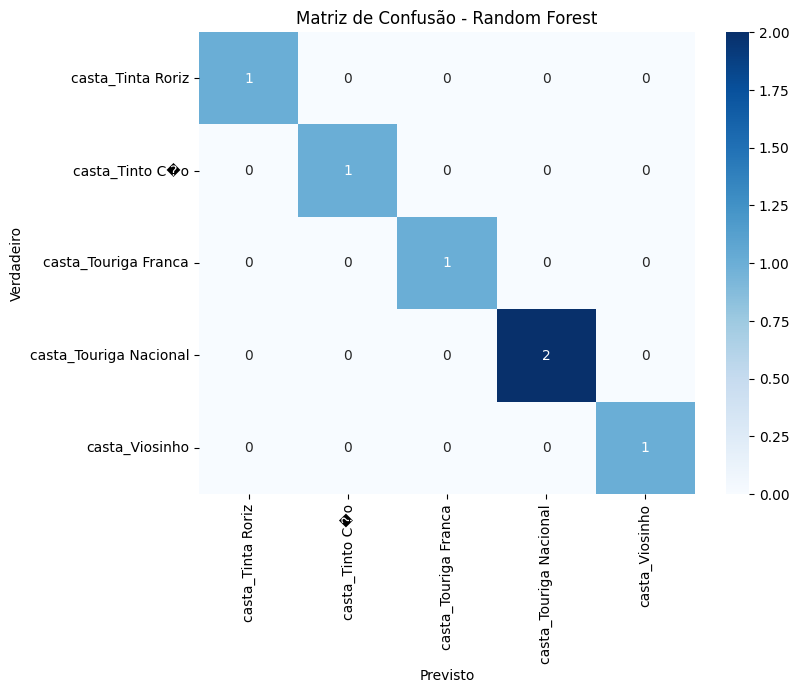

In [20]:
# Matriz de confusão
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.title('Matriz de Confusão - Random Forest')
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.show()

In [21]:
# 5.2 XGBoost (com codificação numérica do target)
# Codificar o target para números
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Treinar XGBoost com os targets codificados
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)
xgb_model.fit(X_train, y_train_encoded)

# Prever e reverter a codificação para comparar com os nomes originais
y_pred_xgb_encoded = xgb_model.predict(X_test)
y_pred_xgb = le.inverse_transform(y_pred_xgb_encoded)

print('XGBoost - Acurácia:', accuracy_score(y_test, y_pred_xgb))
print('\nRelatório de Classificação:')
print(classification_report(y_test, y_pred_xgb))

XGBoost - Acurácia: 1.0

Relatório de Classificação:
                        precision    recall  f1-score   support

     casta_Tinta Roriz       1.00      1.00      1.00         1
       casta_Tinto C�o       1.00      1.00      1.00         1
  casta_Touriga Franca       1.00      1.00      1.00         1
casta_Touriga Nacional       1.00      1.00      1.00         2
        casta_Viosinho       1.00      1.00      1.00         1

              accuracy                           1.00         6
             macro avg       1.00      1.00      1.00         6
          weighted avg       1.00      1.00      1.00         6



In [22]:
# Comparação
print('Comparação de Acurácia:')
print(f'Random Forest: {accuracy_score(y_test, y_pred_rf):.3f}')
print(f'XGBoost: {accuracy_score(y_test, y_pred_xgb):.3f}')

Comparação de Acurácia:
Random Forest: 1.000
XGBoost: 1.000


## 6. Interpretação com SHAP

Vamos usar SHAP para entender quais as features mais importantes para o modelo Random Forest.

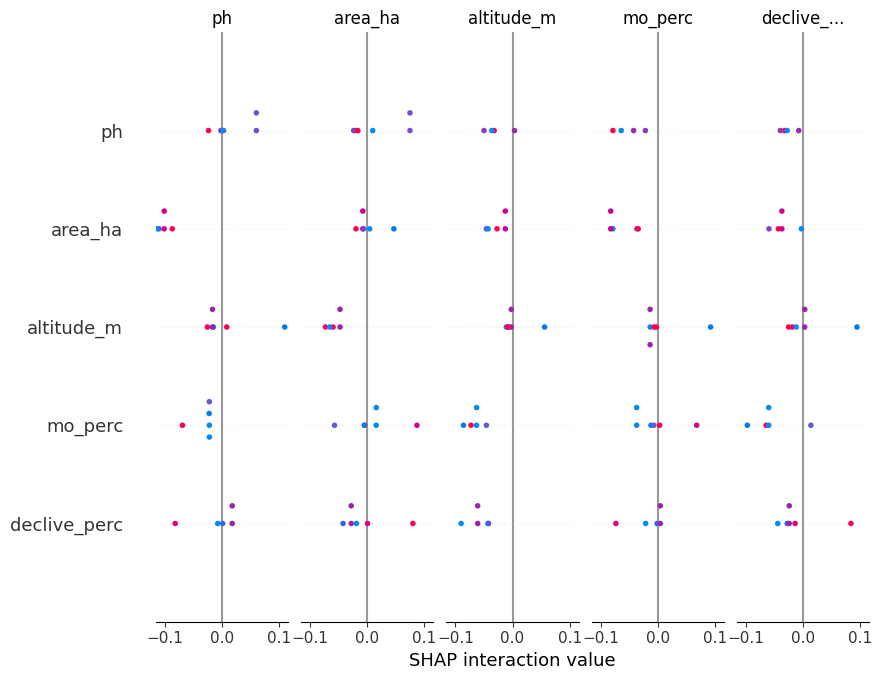

In [23]:
# Criar o explainer e calcular SHAP values
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# Resumo da importância global
shap.summary_plot(shap_values, X_test, feature_names=X.columns, class_names=rf.classes_)

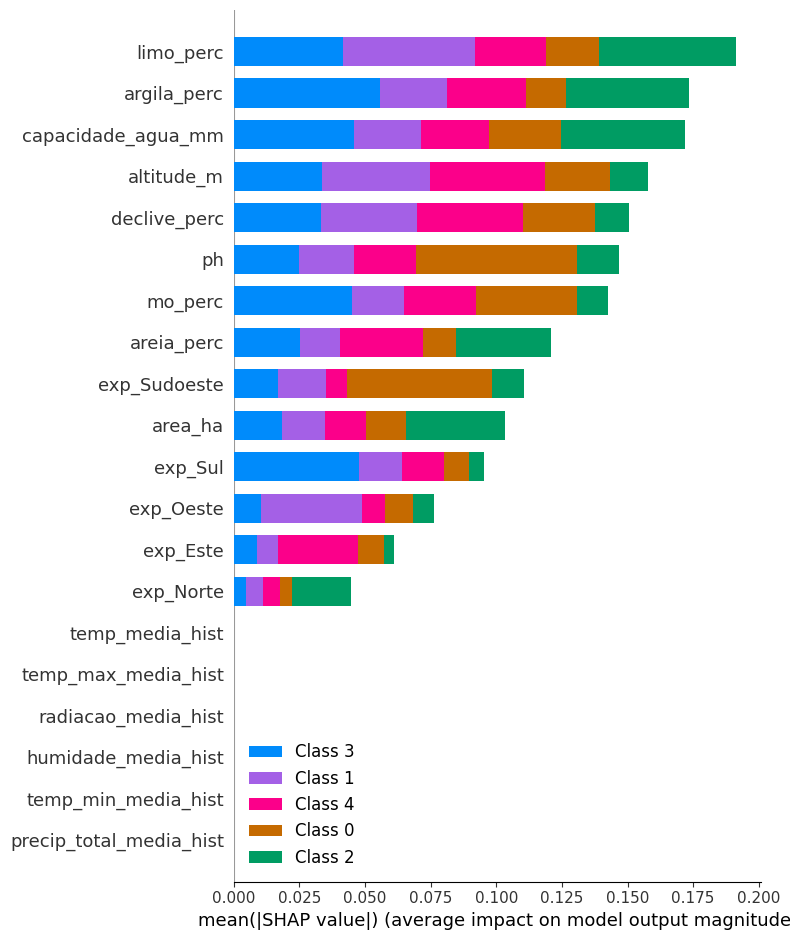

In [24]:
# Importância das features (média |SHAP|)
shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="bar")

## 7. Conclusões

Desempenho dos modelos: Tanto o Random Forest como o XGBoost atingiram uma acurácia de 100% no conjunto de teste, com precision, recall e f1-score perfeitos para todas as castas. Este resultado era esperado, dado que os dados são sintéticos e o problema foi construído com características que separam bem as classes. Apesar da acurácia perfeita, o objetivo principal do notebook – demonstrar o pipeline completo de modelação, incluindo correção de data leakage, codificação de variáveis e interpretação com SHAP – foi cumprido com sucesso.

Importância das features (análise SHAP): Os gráficos SHAP revelaram que as variáveis mais relevantes para a recomendação da casta são, por ordem de importância global:

Textura do solo (percentagens de limo, argila e areia)

Capacidade de água do solo

Altitude e declive do talhão

pH e matéria orgânica

Exposição solar (especialmente Sudoeste, Sul e Oeste)

Estes resultados estão alinhados com o conhecimento agronómico, confirmando que o modelo captou relações realistas entre as características do terreno e a adequação das castas.

Interpretação por casta: A análise SHAP por classe (imagens fornecidas) mostra que cada casta responde de forma diferente às variáveis. Por exemplo:

A casta_Tinta Roriz é mais influenciada pelo limo e capacidade de água.

A casta_Touriga Nacional é sensível à altitude e exposição Sudoeste.

A casta_Viosinho (branca) destaca-se pela importância da matéria orgânica e declive.

Este tipo de interpretação é valioso para produtores e enólogos, pois permite entender porque uma determinada casta é recomendada para um talhão específico.

Validação da abordagem: A correção do data leakage (utilizando médias climáticas históricas fixas em vez de valores anuais) garantiu que o modelo não usa informação do futuro, tornando‑o aplicável em cenários reais de planeamento agrícola.

Limitações e próximos passos:

Os dados são sintéticos e de pequena dimensão (apenas 5 talhões × 6 anos = 30 amostras). Para validação mais robusta, seria necessário aumentar a base de dados com mais talhões, mais anos e eventualmente dados reais.

O passo seguinte natural é a integração deste modelo numa API e o desenvolvimento de um dashboard interativo que permita ao utilizador introduzir características de um novo talhão e obter recomendações em tempo real.

Além disso, o próximo notebook abordará a monitorização com visão computacional, onde treinaremos modelos para deteção de doenças e pragas a partir de imagens sintéticas de videiras.

In [25]:
# 8. Guardar o modelo (opcional)
import joblib
joblib.dump(rf, '../src/models/modelo_recomendacao_castas.pkl')
print('Modelo guardado em src/models/modelo_recomendacao_castas.pkl')

Modelo guardado em src/models/modelo_recomendacao_castas.pkl
